In [2]:
import pandas as pd
import numpy as np
import math
import random
import scipy
import statistics
import statsmodels.formula.api as smf
import sklearn.linear_model as lm

import keras

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
/Users/danielborders/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/danielborders/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/danielborders/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/danielborders

In [3]:
#Global Variables 
train_test_split = .8 #fraction of data to use for training

!ls

README.md                Wine_Data_Analysis.ipynb winequality-red.csv


# Dataset Info:
I will ba anylizing a red wine dataset that has 11 features of wine and corresponding reviews of the wine by critics. The goal is to preict the critics score from the acidity, citric acid, sugar, etc. Becoming a professional wine taster can take years of education, so if we sucessfully create a model to accruaty rate wine from machine producible data, the cost of generating ratings would drasticly decrease. 

In [4]:
pdth = pd.read_csv("winequality-red.csv")
# print(pdth.head())
print("Total Availible Keys: ", len(pdth.keys()))

repl_nan = lambda x: list(map(lambda xx: 0 if math.isnan(xx) else xx, x))

qualtities = list(map(lambda x: int(x), repl_nan(pdth['quality'])))

normalizers = {}
for k in pdth.keys():
    if k in ["quality"]:
        continue
    normalizers[k]=statistics.mean(repl_nan(list(map(lambda x: float(x), pdth[k]))))

xs = []
for k in pdth.keys():
    if k in ["quality"]:
        continue
    xs.append(repl_nan(list(map(lambda x: float(x)/normalizers[k], pdth[k]))))
    
# Put the data into numpy arrays
xs=np.transpose(np.array(xs))
ys=np.array(qualtities)

#Xshape = (num_samples, features), Yshape = (num_samples,)
print("\nPre Split Shapes:")
print("X shape = {}, Y shape = {}".format(xs.shape, ys.shape))

#Create a training and testing split

#Zip the xs and ys together
xsys = list(zip(xs, ys))

#shuffle the combined list
random.shuffle(xsys)

#Unzip the shuffled list
xsk, ysk = zip(*xsys)

splt_ndx = int(len(xsk)*train_test_split)

xs_tr = np.array(xsk[0:splt_ndx]); xs_ts = np.array(xsk[splt_ndx:])
ys_tr = np.array(ysk[0:splt_ndx]); ys_ts = np.array(ysk[splt_ndx:])

#Print the final shapes
print("\nFinal Shapes:")
print("Shapes: X train = {}, Y train = {}".format(xs_tr.shape, ys_tr.shape))
print("        X test  = {},  Y test  = {}".format(xs_ts.shape, ys_ts.shape))

Total Availible Keys:  12

Pre Split Shapes:
X shape = (1599, 11), Y shape = (1599,)

Final Shapes:
Shapes: X train = (1279, 11), Y train = (1279,)
        X test  = (320, 11),  Y test  = (320,)


# Data Analysis
Some minor data analysis to show the coorelation between some of the variables and the quality. It will be intersting to see if there is any correlation or unique combinations of properties lead to a good tasting wine. 

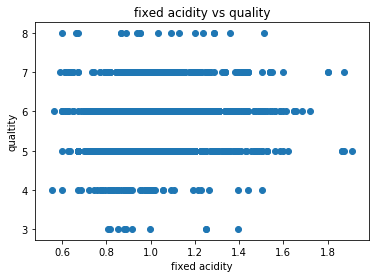

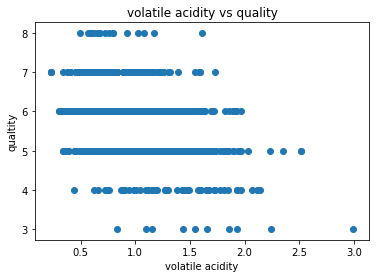

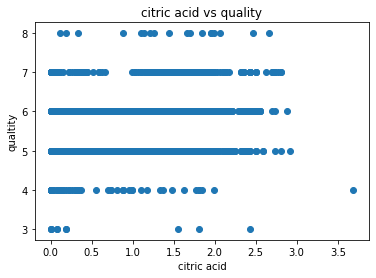

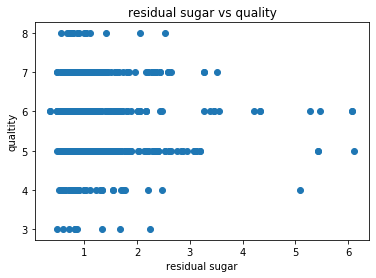

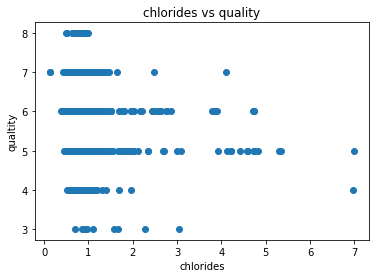

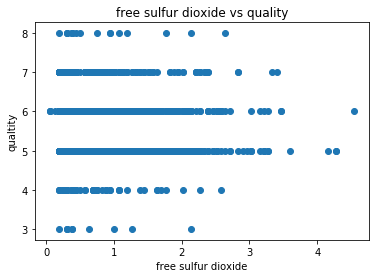

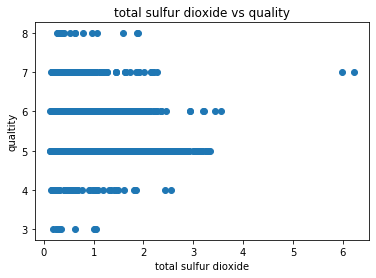

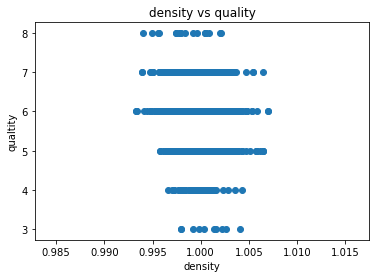

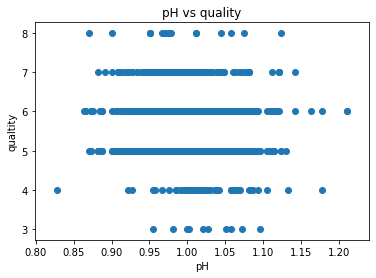

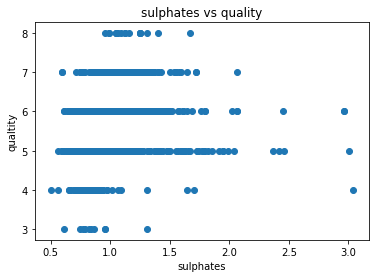

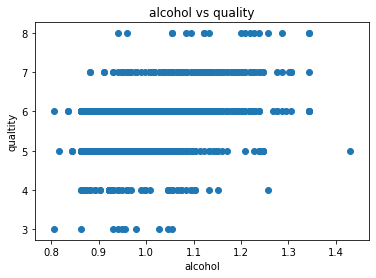

In [44]:
for ii in range(xs.shape[1]):
    plt.figure()
    plt.title(str(pdth.keys()[ii]+" vs quality"))
    plt.scatter(xs[:, ii], ys)
    plt.xlabel(pdth.keys()[ii])
    plt.ylabel("qualtity")

It appears as if the combination of certain preoperties leads to a good tasting wine. However, there are some trends we can see. For example, looking at the volitile acidity vs quality plot, lower quality wines tend to have higher volitile acitdity. I cannot see any other apparent trends from looking at the scatterplots. However; to get a more mathematical relationship, i will examine the covariances of the variables.

In [5]:
for ii in range(xs.shape[1]):
    covvr = np.zeros((xs[:, ii].shape[0], 2))
    covvr[:, 0] = xs[:, ii]
    covvr[:, 1] = ys
    print("COR(", pdth.keys()[ii],", quality) = ", np.cov(np.transpose(covvr))[0,1])

COR( fixed acidity , quality) =  0.020965287537927802
COR( volatile acidity , quality) =  -0.10699827298089089
COR( citric acid , quality) =  0.1314210269587659
COR( residual sugar , quality) =  0.006158425945624326
COR( chlorides , quality) =  -0.056016218766225485
COR( free sulfur dioxide , quality) =  -0.026954908771482794
COR( total sulfur dioxide , quality) =  -0.10582032889554786
COR( density , quality) =  -0.000267473883267283
COR( pH , quality) =  -0.002173837588535154
COR( sulphates , quality) =  0.052288184923756184
COR( alcohol , quality) =  0.03931590469931071


As seen, most covariances are pretty small, however citric acid and volitile acidity appear to play some minor role in directly effecting the quality. 

# Model Fitting
1) Fit a logistic regresion model as a baseline 

2) Fit a fully connected neural network to try to get the best score possible

In [52]:
model_lr = lm.LogisticRegression(solver='liblinear')
model_lr.fit(xs_tr, ys_tr)


def get_acc_lr(x, y, allow_diff=0):
    preds = model_lr.predict(x)
    crr=0
    for xx, yy in zip(preds, y):
        if abs(xx-yy)<=allow_diff:
            crr+=1
    
    return crr/len(y)

print("Training Accuracy = ", get_acc_lr(xs_tr, ys_tr))
print("Testing  Accuracy = ", get_acc_lr(xs_ts, ys_ts))

print("Training Accuracy (allow 1 diff) = ", get_acc_lr(xs_tr, ys_tr, allow_diff=1))
print("Testing  Accuracy (allow 1 diff) = ", get_acc_lr(xs_ts, ys_ts, allow_diff=1))


Training Accuracy =  0.5865184155663655
Testing  Accuracy =  0.58125
Training Accuracy (allow 1 diff) =  0.9638637943015983
Testing  Accuracy (allow 1 diff) =  0.95625


#### Model Analysis
The model fails to have good n+1 precision. While it mostly always gets within 1 of human prediction (seen in the Accuracy (allow 1 diff) metric), the qualties are usually pretty close so n+1 precision is more important. 

Training Accuracy =  0.6914523974982627 , Training Sensitivity =  0.6914523974982627 , Training Specificity =  0.9657169330553625
Testing  Accuracy =  0.6625 , Testing Sensitivity =  0.6625 , Testing Specificity =  0.9625
Training Accuracy (allowed 1 diffrence) =  0.9756775538568451
Testing  Accuracy (allowed 1 diffrence) =  0.975


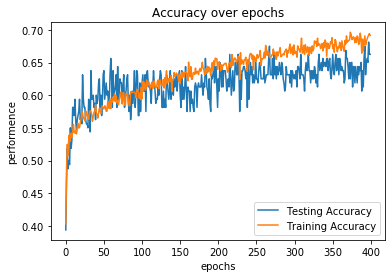

In [74]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

def get_acc_ml(x, y, allow_diff=0):
    preds = model_ml.predict(x)
    crr=0
    tps=tns=fps=fns=0
    num_classes = y.shape[1]

    for xx, yy in zip(preds, y):
        xxp = np.argmax(xx)
        yyp = np.argmax(yy)
        if abs(xxp-yyp)<=allow_diff:
            crr+=1
            
        if xxp==yyp:
            tps+=1
            tns+=num_classes-1

        else:
            fps+=1
            tns+=num_classes-2
            fns+=1
            
    accrc = float(crr)/len(y)
    sensc = float(tps)/(tps+fns)
    spesc = float(tns)/(fps+tns)
    return accrc, sensc, spesc

# Make one hot encodings of the ys 
ys_tr_oh = np.zeros((len(ys_tr), 10))
ys_ts_oh = np.zeros((len(ys_ts), 10))

for i, n in enumerate(ys_tr):
    ys_tr_oh[i, n-1]=1
    
for i, n in enumerate(ys_ts):
    ys_ts_oh[i, n-1]=1

hddn_units = 60
model_ml = Sequential([
    Dense(hddn_units, activation='relu'), 
    Dropout(.5),
    Dense(hddn_units, activation='relu'), 
    Dropout(.25),
    Dense(hddn_units, activation='relu'), 
    Dropout(.25),
    Dense(hddn_units, activation='relu'), 
#     Dropout(.25),
    Dense(40, activation='relu'), 
#     Dropout(.25),
    Dense(10, activation='softmax')
])
model_ml.compile(optimizer='adam', loss='categorical_crossentropy')

eps = 400

accs_ts = []
accs_tr = []
sens = []
spes = []

# model_ml.fit(xs_tr, ys_tr_oh, epochs=eps, verbose=0)


for ee in range(eps):
    model_ml.fit(xs_tr, ys_tr_oh, initial_epoch=ee, epochs=ee+1, verbose=0)
    accr, sensc, spesc = get_acc_ml(xs_ts, ys_ts_oh)
    accs_ts.append(accr)
    sens.append(sensc)
    spes.append(spesc)
    
    accs_tr.append(get_acc_ml(xs_tr, ys_tr_oh)[0])
    
plt.figure()
plt.title("Accuracy over epochs")
plt.xlabel("epochs")
plt.ylabel("performence")
plt.plot(accs_ts)
plt.plot(accs_tr)
plt.legend(["Testing Accuracy", "Training Accuracy"])

tr_acc, tr_sens, tr_spes = get_acc_ml(xs_tr, ys_tr_oh)
ts_acc, ts_sens, ts_spes = get_acc_ml(xs_ts, ys_ts_oh)
print("Training Accuracy = ", tr_acc, ", Training Sensitivity = ", tr_sens, ", Training Specificity = ", tr_spes)
print("Testing  Accuracy = ", ts_acc, ", Testing Sensitivity = ", ts_sens, ", Testing Specificity = ", ts_spes)

print("Training Accuracy (allowed 1 diffrence) = ", get_acc_ml(xs_tr, ys_tr_oh, allow_diff=1)[0])
print("Testing  Accuracy (allowed 1 diffrence) = ", get_acc_ml(xs_ts, ys_ts_oh, allow_diff=1)[0])

try outputting a continuous score instead of a class. Spoiler alert, it didnt work. 

Training Accuracy =  0.6045865184155663 , Training Sensitivity =  0.6045865184155663 , Training Specificity =  0.9560651687128408
Testing  Accuracy =  0.6 , Testing Sensitivity =  0.6 , Testing Specificity =  0.9555555555555556
Training Accuracy (allowed 1 diffrence) =  0.9735927727588604
Testing  Accuracy (allowed 1 diffrence) =  0.96875


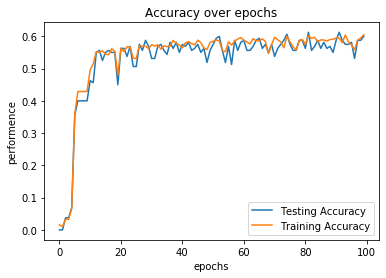

In [91]:
def get_acc_ml2(x, y, allow_diff=0):
    preds = model_ml2.predict(x)
    crr=0
    tps=tns=fps=fns=0
    num_classes = 10

    for xx, yy in zip(preds, y):
        xxp = round(xx[0])
        yyp = int(yy)
        if abs(xxp-yyp)<=allow_diff:
            crr+=1
            
        if xxp==yyp:
            tps+=1
            tns+=num_classes-1

        else:
            fps+=1
            tns+=num_classes-2
            fns+=1
            
    accrc = float(crr)/len(y)
    sensc = float(tps)/(tps+fns)
    spesc = float(tns)/(fps+tns)
    return accrc, sensc, spesc

# Make one hot encodings of the ys 

hddn_units = 60
model_ml2 = Sequential([
    Dense(hddn_units, activation='relu'), 
    Dropout(.5),
    Dense(hddn_units, activation='relu'), 
    Dropout(.25),
    Dense(hddn_units, activation='relu'), 
    Dropout(.25),
    Dense(hddn_units, activation='relu'), 
#     Dropout(.25),
    Dense(40, activation='relu'), 
#     Dropout(.25),
    Dense(1, activation='relu')
])
model_ml2.compile(optimizer='adam', loss='mse')

eps = 100

accs_ts = []
accs_tr = []
sens = []
spes = []


for ee in range(eps):
    model_ml2.fit(xs_tr, ys_tr, initial_epoch=ee, epochs=ee+1, verbose=0, batch_size=8)
    accr, sensc, spesc = get_acc_ml2(xs_ts, ys_ts)
    accs_ts.append(accr)
    sens.append(sensc)
    spes.append(spesc)
    
    accs_tr.append(get_acc_ml2(xs_tr, ys_tr)[0])
    
plt.figure()
plt.title("Accuracy over epochs")
plt.xlabel("epochs")
plt.ylabel("performence")
plt.plot(accs_ts)
plt.plot(accs_tr)
plt.legend(["Testing Accuracy", "Training Accuracy"])

tr_acc, tr_sens, tr_spes = get_acc_ml2(xs_tr, ys_tr)
ts_acc, ts_sens, ts_spes = get_acc_ml2(xs_ts, ys_ts)
print("Training Accuracy = ", tr_acc, ", Training Sensitivity = ", tr_sens, ", Training Specificity = ", tr_spes)
print("Testing  Accuracy = ", ts_acc, ", Testing Sensitivity = ", ts_sens, ", Testing Specificity = ", ts_spes)

print("Training Accuracy (allowed 1 diffrence) = ", get_acc_ml2(xs_tr, ys_tr, allow_diff=1)[0])
print("Testing  Accuracy (allowed 1 diffrence) = ", get_acc_ml2(xs_ts, ys_ts, allow_diff=1)[0])

### Model analysis
The fully connected network was able to increase testing accuracy from the baseline by about 8% 

1)overfitting was reduced by addin dropout between layers. The dropout was added to the first 3 layers. Zeroing out some of the weights. 

2) Performence was measured using 3 metrics. Accuracy, Sensitivity and Specificity. Note, due to the problem, specificity and accuracy are equivalent.
    These were recorded at each epoch and plotted at the end of training. 
    
Performance was evaluated using 2 diffrent strategies. Since ratings are slightly subjective, accuracy with an allowance of 1 diffrence was used. This accuracy was above 95% for both the training and testing set, meaning our model is accuratly "ballparking" the rating. Furthermore, the n+1 accuracy was measured using 3 metrics: accuracy in terms of number of correct ratings/total; sensitivity = tp/tp+fns; specificity = tns/tns+fps